In [1]:
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import zscore, linregress, pearsonr
from matplotlib.colors import LogNorm
import os
import pycwt as cwt
import pickle

In [2]:
FS = 4 # E4 sampling rate

SAVE_CWT_FOLDER = '/media/bayesian-posterior/sdc/sensecode_data/downsample_eda_cwt_data/'

DATA_FOLDER_PATH = '/media/bayesian-posterior/sdc/sensecode_data/'
DATA_FOLDER = os.fsencode(DATA_FOLDER_PATH)

# DAYS_ARRAY = np.asarray([0.5, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31])
# FREQ_ARRAY = 1 / (DAYS_ARRAY * 24) # for morlet
# FREQ_NAMES = ["{:.1f}".format(day)+' Day(s)' for day in DAYS_ARRAY]

PANDAS_RESAMPLE_RATE = "{:.2f}".format(1/FS)+'S' # find missing samples (datetime)
# PANDAS_RESAMPLE_RATE = 'T'

# wavelet and filter variables                    
mother = cwt.Morlet(6)


In [3]:
HDRS_17_CUTOFF = 20
HDRS_24_CUTOFF = 10
RCI_HDRS_17 = 6

HDRS_variant = 'hamd_17_score'

LABEL_FOLDER_PATH = 'labels/'

In [4]:
def plot_signal(df_eda,
                fs,
                label,
                ylim = None):
    
    plt.figure(figsize=(15, 5))
    
    t = df_eda.index.to_series()
    x = df_eda[label]
    xtick_freq = int(fs*60*60*24*7)
    
    plt.plot(range(len(t)), x, label = label)
    plt.legend(loc=1)
    plt.xticks(range(len(t))[::xtick_freq], t[::xtick_freq], rotation='vertical')

    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel('Date')
    plt.ylabel('EDA [uS]')
    plt.grid()

In [5]:
def remove_artifacts_and_interpolate(df_eda, 
                     fs, 
                     pandas_resample_rate,
                                     interpolate_method = 'time',
                                     z_score = True):
    
    df_eda_without_artifacts = df_eda.resample(pandas_resample_rate).mean()
    
    # df_eda_without_artifacts['hour'] = df_eda_without_artifacts.index.to_series().apply(lambda x : x.hour)    
    # df_eda_without_artifacts['eda'] = df_eda_without_artifacts.groupby('hour', group_keys=False)['eda'].apply(lambda x: x.fillna(x.mean()))
    
    df_eda_without_artifacts.fillna(df_eda_without_artifacts['eda'].median(), inplace=True)
    
    if z_score:
        print('z-scored')
        df_eda_without_artifacts['eda'] = zscore(df_eda_without_artifacts['eda'])
        

    return df_eda_without_artifacts

In [6]:
def apply_fir(eda: np.ndarray,
              fs,
              cutoff,
              filter_type, # bandpass, lowpass, highpass, bandstop
              transition_band,
              window) -> np.ndarray:
    
    if window == 'hann' or window == 'hamming' or window == 'bartlett':
        M = int(4 * fs / transition_band)
    elif window == 'blackman':
        M = int(6 * fs / transition_band)
    else:
        raise ValueError('Length estimation for this window not implemented')
        
    # print('Using ' + window + ' window for ' + filter_type + ' FIR filter.')
    h = signal.firwin(numtaps = M, 
                      cutoff = cutoff,
                      fs = fs,
                      pass_zero = filter_type,
                      window = window)
    
    eda = np.squeeze(eda)
    return signal.lfilter(h, [1.0], eda) 
    # return signal.filtfilt(h, [1.0], eda) # avoid phase shift of single filter

In [7]:
def morlet_wavelet(eda: np.ndarray, 
                   fs, 
                   freq_arr, 
                   w = 6):
    
    widths = w * fs / (2 * freq_arr * np.pi)
    cwtm = signal.cwt(eda, signal.morlet2, widths, w = w)
    
    return np.abs(cwtm)


In [8]:
# all_peaks_dict = {}
# all_power_dict = {}

# sig_peaks_dict = {}
# sig_power_dict = {}

# for file in os.listdir(DATA_FOLDER):
    
#     filename = os.fsdecode(file)
    
#     if filename.endswith("worn_left.h5"):
        
#         subject = filename.split('_')[0]
#         eda_filepath = DATA_FOLDER_PATH+filename
        
#         print(eda_filepath, subject)
        
#         df_eda = pd.read_hdf(eda_filepath)

#         # plot_signal(df_eda = df_eda, label = 'eda', fs = FS)
#         df_eda_without_artifacts = remove_artifacts_and_interpolate(df_eda = df_eda, 
#                                                                     fs = FS, 
#                                                                     pandas_resample_rate = PANDAS_RESAMPLE_RATE, 
#                                                                     z_score = True)
        
#         # delta = df_eda_without_artifacts.index[-1] - df_eda_without_artifacts.index[0]
#         # n = delta.total_seconds()/3600/2
#         # freqs = np.append(np.arange(20, 28, 1), np.arange(28, 3*24, 4))
#         # freqs = np.append(freqs, np.arange(3*24, 8*24, 6))
#         # freqs = np.append(freqs, np.arange(8*24, int(n), 12))
#         freqs = np.append(np.arange(23, 25, 1), np.arange(6*24, 8*24, 12))
#         freqs = (1/freqs)
#         # freqs = FREQ_ARRAY
        
#         # wavelet
#         y = df_eda_without_artifacts.resample('T').median()['eda'].to_numpy()
#         dt = 1/60
#         alpha, _, _ = cwt.ar1(y) # lag 1 autocorrelation for significance
#         wave, scales, freqs, coi, fft, fftfreqs = cwt.cwt(signal = y, dt = dt, wavelet = mother, freqs = freqs)
#         power = np.abs(wave) ** 2 # [len(freq), t]
#         fft_power = np.abs(fft) ** 2
#         period = 1 / freqs
        
#         # save downsampled cwt of each subject
#         subject_cwt_df = pd.DataFrame(power.T, columns = [str(p) for p in period])
#         cwt_h5_name = SAVE_CWT_FOLDER + subject + '_cwt.h5'
#         subject_cwt_df.index = df_eda_without_artifacts.resample('T').median().index
#         subject_cwt_df.to_hdf(cwt_h5_name, key='df', mode='w')
        
#         glbl_power = power.mean(axis=1) # len(freqs)
#         dof = y.size - scales  # Correction for padding at edges
#         var = y.std()**2
#         glbl_signif, tmp = cwt.significance(var, dt, scales, 1, alpha, significance_level=0.99, dof=dof, wavelet=mother)
#         # signif, fft_theor = cwt.significance(1.0, dt, scales, 0, alpha, significance_level=0.99, wavelet=mother)
        
#         # Find peaks that are significant
#         xpeaks = []; powers = []
#         ind_peaks = signal.find_peaks(var * glbl_power)[0]
#         for i in ind_peaks:
#             peak = [var * glbl_power > glbl_signif][0][i]
#             if peak:
#                 if period[i] not in xpeaks:
#                     xpeaks.append(period[i])
#                     powers.append([var * glbl_power][0][i])

#         # keep only stongest peak if there is a peak within +/- 33% of another peak
#         # xpeaks = np.array(xpeaks)  
#         # new_xpeaks = {}
#         # for peak in xpeaks:
#         #     ints2 = np.where(np.logical_and(xpeaks>=peak-0.33*peak, xpeaks<=peak+0.33*peak))
#         #     # is the peak in another peaks BP filter?
#         #     other = [i for i,p in enumerate(xpeaks) if peak >= p - 0.33*p and peak <= p + 0.33*p]
#         #     ints2 = set(np.array(list(ints2[0]) + other))
#         #     if len(ints2):
#         #         # if there is a peak within +/- 33%, check the power of it, choose highest
#         #         max_peak = xpeaks[[var * glbl_power][0].tolist().index(np.max([[var * glbl_power][0][i] for i in ints2]))]
#         #         new_xpeaks[peak] = max_peak
#         # xpeaks = sorted(set(new_xpeaks.values()))
        
#         assert len(xpeaks) == len(powers)
#         print(xpeaks)
#         sig_peaks_dict[subject] = xpeaks
#         sig_power_dict[subject] = powers


In [9]:
# file1 = open('sig_peaks_eda_dict.pkl', 'wb')
# pickle.dump(sig_peaks_dict, file1)

# file2 = open('sig_power_eda_dict.pkl', 'wb')
# pickle.dump(sig_power_dict, file2)

In [10]:
def scatter_plot_power_vs_hdrs(all_power_slope_vec, 
                               all_hdrs_slope_vec, 
                               subject_significance_list, 
                               corr_result):
    
    colors = {'significant':'green', 'not significant':'red'}
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.scatter(all_power_slope_vec, 
               all_hdrs_slope_vec, 
               c = [colors[sig] for sig in subject_significance_list])
    
    ax.plot(all_power_slope_vec, 
            corr_result.intercept + corr_result.slope*np.asarray(all_power_slope_vec), 
            c = 'blue', 
            alpha = 0.5,
            label = 'Correlation = ' + str(round(corr_result.rvalue, 2)))
    
    ax.text(x = -0.05, 
            y = 0, 
            s = 'p = ' + str(round(corr_result.pvalue, 2)), 
            weight = 'bold', 
            size = 10)
    
    ax.legend(loc = 1)
    ax.grid(True)
    ax.set_xlabel('Slope of Circadian EDA Rhythm Power Over 12 Weeks')
    ax.set_ylabel('Slope of HDRS Over 12 Weeks')

In [20]:
def linregress_power_and_hrds(df_cwt,
                              freq, 
                            subject,
                            HDRS_array):
    
    HDRS_array = zscore(HDRS_array)
    power_array = df_cwt.resample('D').mean()[freq]
    
    hdrs_slope, hdrs_intercept, _, _, _ = linregress(HDRS_array, np.arange(len(HDRS_array)))
    
    power_slope, power_intercept, _, _, _ = linregress(power_array, np.arange(len(power_array)))
    power_slope *= -1
                
    return hdrs_slope, hdrs_intercept, power_slope, power_intercept

In [21]:
file1 = open('sig_peaks_eda_dict.pkl', 'rb')
sig_peaks_dict = pickle.load(file1)

file2 = open('sig_power_eda_dict.pkl', 'rb')
sig_power_dict = pickle.load(file2)

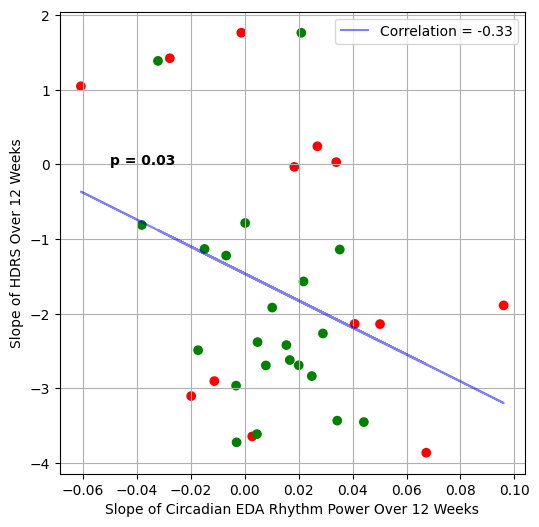

In [22]:
all_hdrs_slope_vec, all_power_slope_vec, subject_significance_list = [], [], []
test_freq = 1.0*24

for file in os.listdir(SAVE_CWT_FOLDER):
    
    filename = os.fsdecode(file)
    
    if filename.endswith("cwt.h5"):
        
        subject = filename.split('_')[0]
        # print(subject)
        eda_filepath = SAVE_CWT_FOLDER+filename
        df_cwt = pd.read_hdf(eda_filepath, 'df')
        
        HDRS_file_name = LABEL_FOLDER_PATH + subject + '_HDRS.csv'
        HDRS_df = pd.read_csv(HDRS_file_name)
        HDRS_array = HDRS_df[HDRS_variant].interpolate().to_numpy() # in case of missed HDRS assessment       

        hdrs_slope, hdrs_intercept, power_slope, power_intercept = linregress_power_and_hrds(df_cwt, 
                                                                                            freq = str(test_freq),
                                                                                            subject = subject,
                                                                                            HDRS_array = HDRS_array)

        all_hdrs_slope_vec.append(hdrs_slope)
        all_power_slope_vec.append(power_slope)
        
        if test_freq in sig_peaks_dict[subject]:
            subject_significance_list.append('significant')
        else:
            subject_significance_list.append('not significant')



result = linregress(all_power_slope_vec, all_hdrs_slope_vec, alternative = 'less')

scatter_plot_power_vs_hdrs(all_power_slope_vec, 
                           all_hdrs_slope_vec, 
                           subject_significance_list, 
                           result)

In [14]:
def plot_peak_power_dist(sig_peaks_dict, sig_power_dict):
    
    sig_peaks_list = []
    avg_power_dict = {}
    
    for subject, peaks in sig_peaks_dict.items():
        
        sig_peaks_list += peaks

        for idx, p in enumerate(peaks):
            rounded_peak = round(p, 0)
            if rounded_peak in avg_power_dict.keys():
                avg_power_dict[rounded_peak].append(p)
            else:
                avg_power_dict[rounded_peak] = [p]
    
    rounded_peak_vec = list(avg_power_dict.keys())
    avg_power_vec = []
    sd_power_vec = []
    for rounded_peak in rounded_peak_vec:
        avg_power_vec.append(np.mean(avg_power_dict[rounded_peak]))
        sd_power_vec.append(np.std(avg_power_dict[rounded_peak]))
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    # make a little extra space between the subplots
    fig.subplots_adjust(hspace=0.5)

    ax1.hist(sig_peaks_list, bins = 'auto', color = 'red', alpha = 0.5)
    ax1.set_xlabel('Period [Hour]')
    ax1.set_ylabel('Number of Subjects')
    ax1.grid(True)
    
    vline_labels = ['1 Day', '7 Days', '30 Days']
    vline_positions = [24, 24*7, 24*30]
    for label, position in zip(vline_labels, vline_positions):
        ax1.axvline(position, color = 'green', label = label)
    ax1.legend(loc=1)
    ax1.set_title('Number of subjects with significant peaks at different periods')
    
#     ax2.errorbar(rounded_peak_vec, 
#                  avg_power_vec, 
#                  fmt = 'o',
#                  yerr = sd_power_vec, 
#                  capsize = 5,
#                  lw = 1,
#                  label ='1 SD')
    
#     ax2.set_xlabel('Period [Hour]')
#     ax2.set_ylabel('Average Power')

#     for label, position in zip(vline_labels, vline_positions):
#         ax2.axvline(position, color = 'green', label = label)
#     ax2.legend(loc=1)
#     ax2.set_title('Average power of significant peaks at different periods over all subjects')
#     ax2.grid(True)


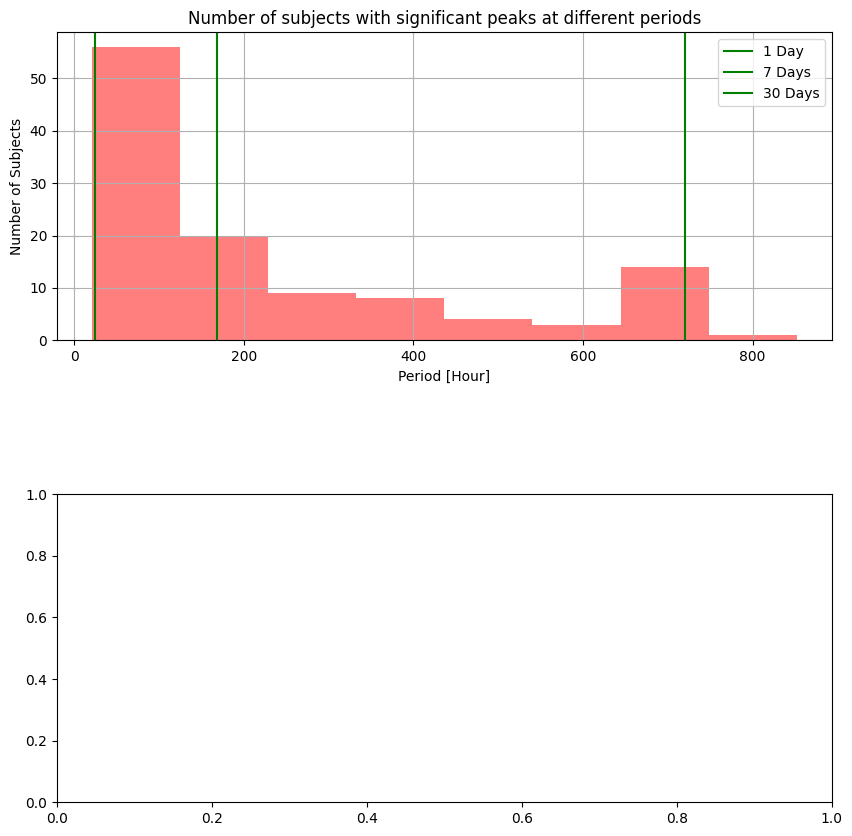

In [15]:
plot_peak_power_dist(sig_peaks_dict, sig_power_dict)